In [1]:
import rasterio
import geopandas
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt
import os
import numpy as np
import pickle
import copy

In [17]:
dataset = rasterio.open('data/images/2017-01-01/full/B01.jp2', 'r')# /full/B02.jp2', 'r')

In [18]:
transform = dataset.transform
transform

Affine(60.0, 0.0, 499980.0,
       0.0, -60.0, 6900040.0)

In [19]:
CRS = dataset.crs
CRS
CRS = rasterio.crs.CRS.from_string("EPSG:32734")
CRS

CRS.from_epsg(32734)

In [20]:
polygons_path = "data/train/train.shp"

In [21]:
train_labels = geopandas.read_file(polygons_path)

In [22]:
train_labels.head()

,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
0,1,0.915905,3,8,POLYGON ((2467881.175041331 -3352032.059296422...
1,2,2.064410,3,6,"POLYGON ((2468428.90623293 -3351993.17305059, ..."
2,3,1.080300,3,8,POLYGON ((2468333.745293362 -3352058.485056543...
3,4,1.316190,3,8,POLYGON ((2468607.857733211 -3352012.337531495...
4,7,5.529220,3,8,"POLYGON ((2468646.08520868 -3351706.201920062,..."


In [23]:
train_labels[train_labels['geometry'].isna()]

,Field_Id,Area,Subregion,Crop_Id_Ne,geometry
800,1170,0.0,0,8,None
1162,1685,0.0,0,8,None
2402,3472,0.0,0,6,None


In [24]:
train_labels = train_labels.dropna()

In [25]:
train_labels = train_labels.to_crs(CRS)

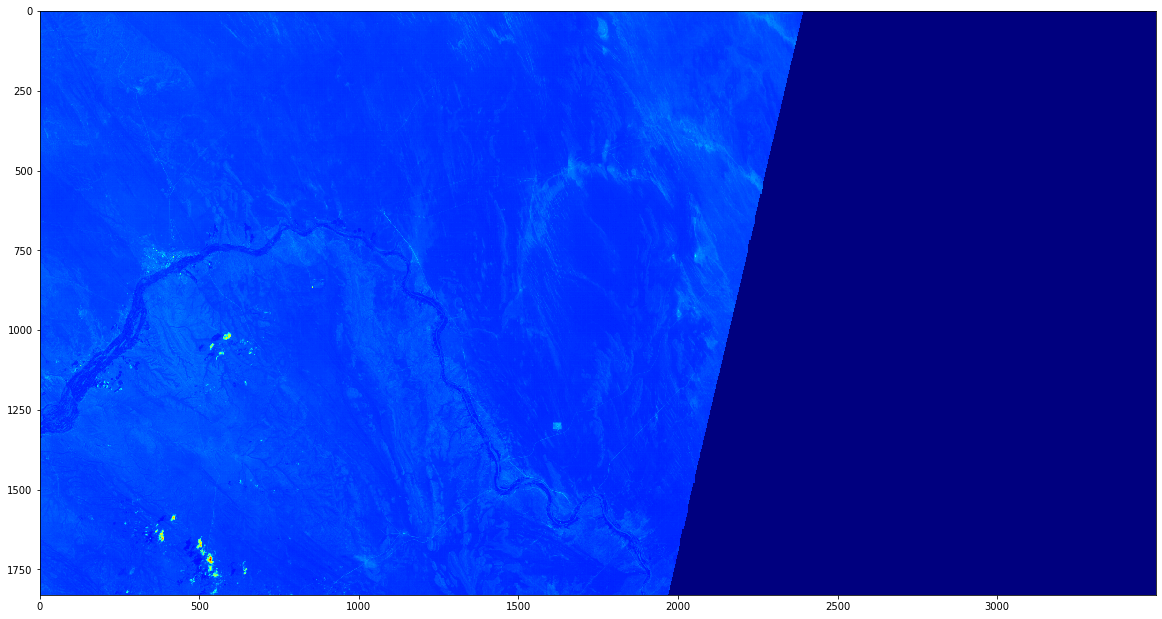

In [26]:
plt.figure(figsize=(20,15))
show(dataset.read(), cmap='jet')

In [27]:
field = train_labels.iloc[0]

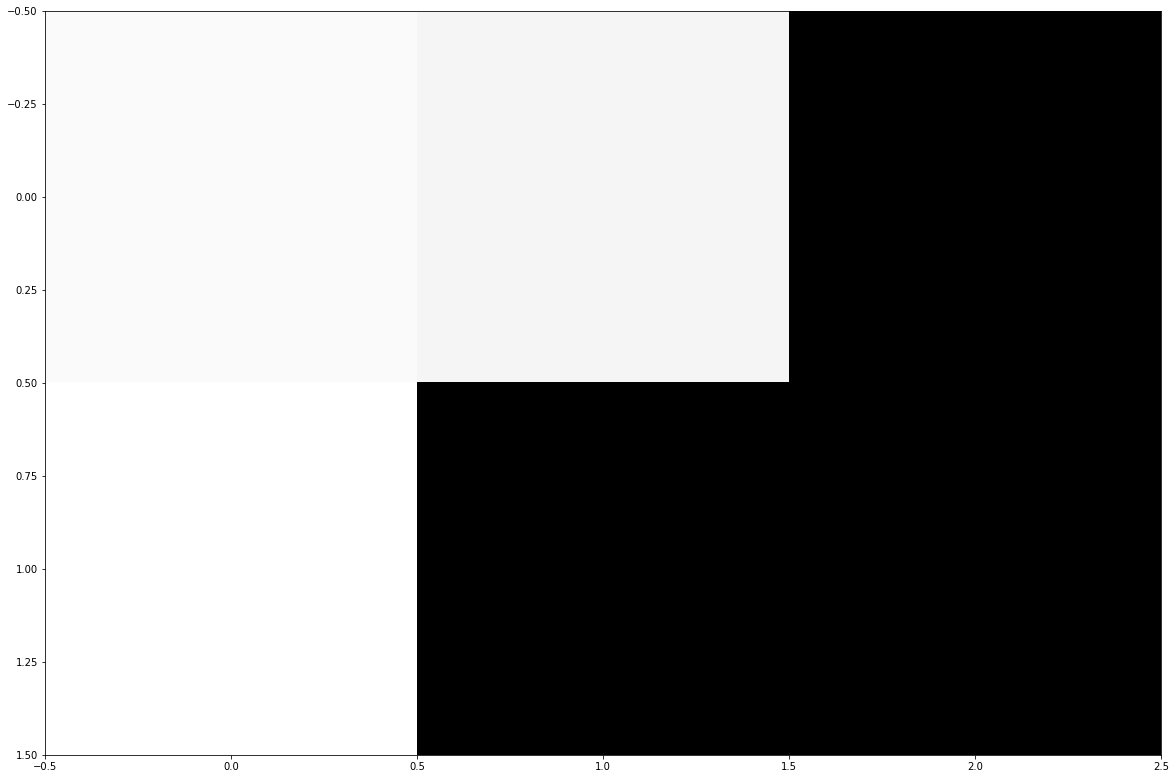

In [28]:
masked, trans_masked = mask(dataset, [field['geometry']], nodata=0, crop=True)
plt.figure(figsize=(20,15))
show(masked, cmap='gray')

In [29]:
masked

array([[[1147, 1123,    0],
        [1170,    0,    0]]], dtype=uint16)

## Normalization

In [305]:
def normalize(x, x_min, x_max, a=0, b=255):
    x[x < x_min] = x_min
    x[x > x_max] = x_max
    x_norm = (b - a) * ((x - x_min) / (x_max - x_min)) + a
    x_norm[x_norm < a] = a
    x_norm[x_norm > b] = b
    return x_norm

def IQR_masked(dist):
    dist = dist.compressed()
    return np.percentile(dist, 75) - np.percentile(dist, 25)

In [204]:
norm_dict ={
    "B01": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B02": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B03": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B04": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B05": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B06": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B07": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B08": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B8A": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B09": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B10": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B11": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B11": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
    "B12": {
            'min': [],
            'max': [],
            'median': [],
            'IQR': []
           },
}
full_norm_dict = norm_dict.copy()

In [208]:
IMAGES_PATH = "data/images/"
dates = os.listdir(IMAGES_PATH)

for date in dates:
    for band in norm_dict.keys():
        with rasterio.open(os.path.join(IMAGES_PATH, date, 'full', band+'.jp2')) as dataset:
            polys_only, trans_masked = mask(dataset, list(train_labels['geometry']), nodata=0)
            mask_ = polys_only == 0
            raster = np.ma.array(polys_only, mask=mask_)
            min_ = raster.min()
            max_ = raster.max()
            median_ = np.ma.median(raster)
            IQR_ = IQR_masked(raster)
            
        norm_dict[band]['min'].append(min_)
        norm_dict[band]['max'].append(max_)
        norm_dict[band]['median'].append(median_)
        norm_dict[band]['IQR'].append(IQR_)

In [212]:
with open('data/stats.pkl' ,'wb') as f:
    pickle.dump(norm_dict, f)

In [ ]:
full_norm_dict = copy.deepcopy(norm_dict)

In [218]:
for band_name, band in norm_dict.items():
    for metric_name, metric in band.items():
        full_norm_dict[band_name][metric_name] = np.mean(metric)

In [226]:
norm_values = {}
for band_name, band in full_norm_dict.items():
    norm_values[band_name] = {}
    median = full_norm_dict[band_name]['median']
    IQR = full_norm_dict[band_name]['IQR']
    q1 = median - IQR/2 
    q3 = median + IQR/2
    ceiling = q3 + 1.5*IQR
    floor = q1 - 1.5*IQR
    norm_values[band_name]['min'] = floor
    norm_values[band_name]['max'] = ceiling

In [227]:
norm_values

{'B01': {'min': 1019.7272727272727, 'max': 1417.9090909090908},
 'B02': {'min': 671.9090909090909, 'max': 1332.6363636363635},
 'B03': {'min': 561.3181818181818, 'max': 1371.1363636363637},
 'B04': {'min': 92.81818181818187, 'max': 1820.818181818182},
 'B05': {'min': 569.5454545454546, 'max': 1991.909090909091},
 'B06': {'min': 1009.8181818181818, 'max': 3514.181818181818},
 'B07': {'min': 1051.6363636363637, 'max': 4326.909090909091},
 'B08': {'min': 993.454545454545, 'max': 4308.0},
 'B8A': {'min': 1227.8181818181818, 'max': 4767.090909090909},
 'B09': {'min': 458.6363636363637, 'max': 1414.5454545454545},
 'B10': {'min': -22.545454545454547, 'max': 44.36363636363636},
 'B11': {'min': 949.4545454545457, 'max': 3425.090909090909},
 'B12': {'min': 159.909090909091, 'max': 2475.5454545454545}}

In [156]:
print(masked.min())
print(masked.max())

0
1238


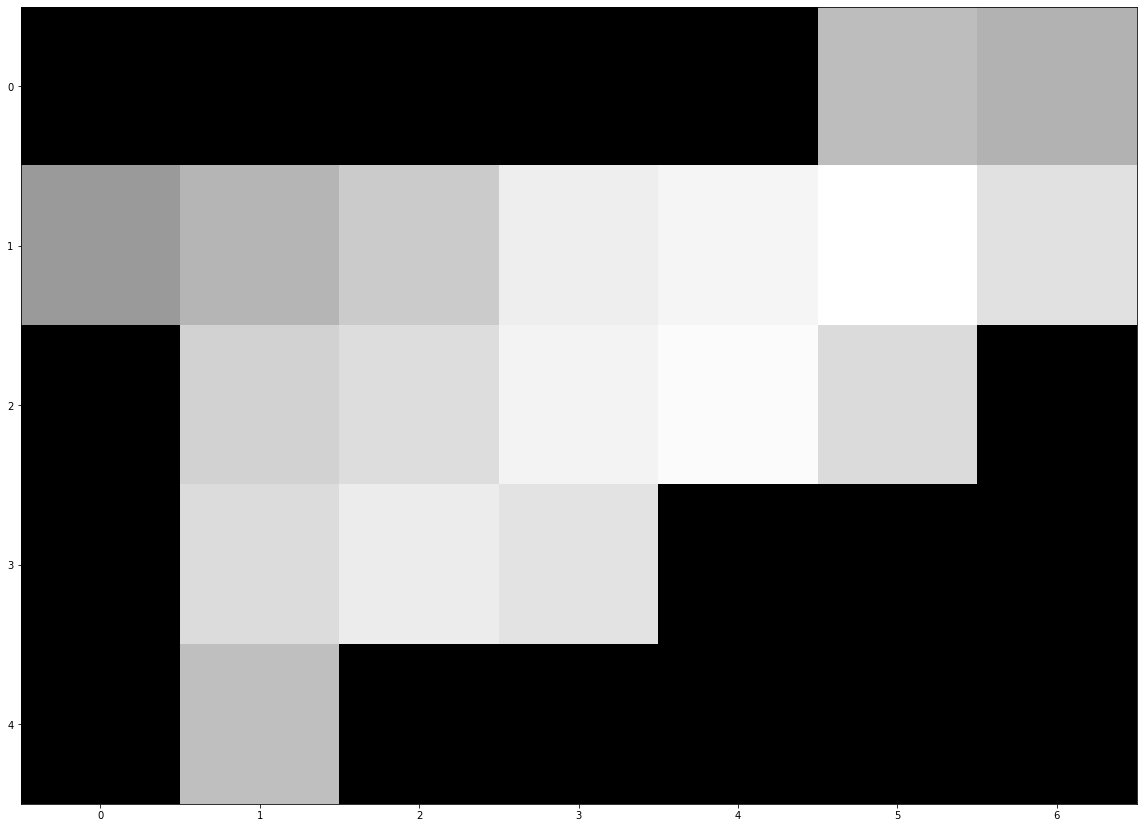

In [311]:
mask_ = (masked == 0)
print(mask_)
masked = np.ma.array(masked, mask=mask_)
norm_mask = normalize(masked, 1227.8181818181818, 4767.090909090909, 0, 1)
plt.figure(figsize=(20,15))
show(norm_mask, cmap='gray')

In [312]:
norm_mask

array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.71827802, 0.67730915],
        [0.58463475, 0.68832837, 0.77167882, 0.90475701, 0.92962088,
         0.97087229, 0.85587691],
        [0.        , 0.79710778, 0.84118463, 0.92283982, 0.95307202,
         0.83242577, 0.        ],
        [0.        , 0.8358163 , 0.89628069, 0.86209288, 0.        ,
         0.        , 0.        ],
        [0.        , 0.72618925, 0.        , 0.        , 0.        ,
         0.        , 0.        ]]])

In [315]:
import pandas

In [316]:
df = pandas.DataFrame(
    columns=[
        "Field_Id",
        "Subregion",
        "Crop_Id_Ne",
        "2017-01-01",
        "2017-01-31",
        "2017-02-10",
        "2017-03-12",
        "2017-03-22",
        "2017-05-31",
        "2017-06-20",
        "2017-07-10",
        "2017-07-15",
        "2017-08-04",
        "2017-08-19",
    ]
)

In [320]:
df.loc[2] = [3, 1, 1, 1,None,1,1,1,1,1,1,1,1,1,]

In [321]:
df

,Field_Id,Subregion,Crop_Id_Ne,2017-01-01,2017-01-31,2017-02-10,2017-03-12,2017-03-22,2017-05-31,2017-06-20,2017-07-10,2017-07-15,2017-08-04,2017-08-19
3,3,1,1,1,1,1,1,1,1,1,1,1,1,1
2,3,1,1,1,NaN,1,1,1,1,1,1,1,1,1
